# COVID-19 Prediction Using Stateful LSTM (Timeseries/Forecast Prediction)

Procedure:

1. Preparing requirements
2. Getting dataset
3. Preparing functions
4. Preparing data & model
5. Testing the model before going to the future prediction
6. Doing future prediction


Note: <u><i>Maybe I did it with some mistake, please show me how to do it better</i></u>

## Preparing requirements

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
TRAIN_CASE = 'new_cases'
TRAIN_LOCATION = 'Indonesia'
DATATRAIN_SOURCE_FILE = 'covid19_full_data.csv'
TEST_SIZE = 0.3
LOOK_BACK = 1
BATCH_SIZE = 1
EPOCHS = 2000
DAYS_TO_PREDICT = 30

In [3]:
np.random.seed(RANDOM_SEED)

## Getting dataset

In [4]:
df = pd.read_csv(DATATRAIN_SOURCE_FILE)
if TRAIN_LOCATION:
    df = df.loc[df['location']==TRAIN_LOCATION]
df.drop(['location'], axis=1, inplace=True)
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2019-12-31,0,0,0,0
2020-01-01,0,0,0,0
2020-01-02,0,0,0,0
2020-01-03,0,0,0,0
2020-01-04,0,0,0,0


Gettin train case & removing all zero values

In [6]:
cases = df.filter([TRAIN_CASE])
cases = cases[(cases.T != 0).any()]

In [7]:
cases.head()

,new_cases
date,
2020-03-02,2
2020-03-07,2
2020-03-09,2
2020-03-11,13
2020-03-12,15


Plotting train case data

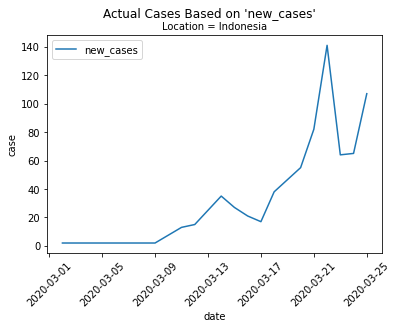

In [8]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

In [9]:
cases.shape

(16, 1)

## Preparing functions

This will split data into X & Y value

In [10]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

## Preparing data & model

Creating train & test data for testing

In [11]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [12]:
train_cases.shape

(12, 1)

In [13]:
test_cases.shape

(4, 1)

Data normalization

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [15]:
all_cases.shape

(16, 1)

In [16]:
train_cases.shape

(12, 1)

In [17]:
test_cases.shape

(4, 1)

Splitting data to get X & Y value

In [18]:
look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

In [19]:
X_all.shape

(14, 1)

In [20]:
X_train.shape

(10, 1)

In [21]:
X_test.shape

(2, 1)

We need to convert the shape of the data to LSTM shape format (samples, timesteps, features)

To make a model can learning from a sequence, we'll using timesteps for timeseries prediction

In [22]:
X_all = np.array(X_all).reshape(X_all.shape[0], 1, 1)
Y_all = np.array(Y_all).reshape(Y_all.shape[0], 1)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, 1)
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 1, 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

In [23]:
X_all.shape

(14, 1, 1)

In [24]:
Y_all.shape

(14, 1)

In [25]:
X_train.shape

(10, 1, 1)

In [26]:
Y_train.shape

(10, 1)

In [27]:
X_test.shape

(2, 1, 1)

In [28]:
Y_test.shape

(2, 1)

And, this is the LSTM timeseries prediction model

In [29]:
batch_size = BATCH_SIZE
model = Sequential()
model.add(LSTM(4, return_sequences=True, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=True))
model.add(LSTM(1, stateful=True))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 4)                 96        
_________________________________________________________________
lstm_2 (LSTM)                (1, 1)                    24        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    2         
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
None


## Testing the model before going to the future prediction

Fitting the model with train data

In [30]:
epoch = EPOCHS
loss = []
for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    model.reset_states()

Iteration 1/2000
Epoch 1/1
10/10 [==============================] - 1s 80ms/step - loss: 0.5692
Iteration 2/2000
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.5331
Iteration 3/2000
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.5003
Iteration 4/2000
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.4696
Iteration 5/2000
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.4395
Iteration 6/2000
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.4095
Iteration 7/2000
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.3799
Iteration 8/2000
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.3510
Iteration 9/2000
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.3233
Iteration 10/2000
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.2973
Iteration 11/2000
Epoch 1/1
10/10 [=============

Plotting model loss history

Lower `loss` provide better prediction

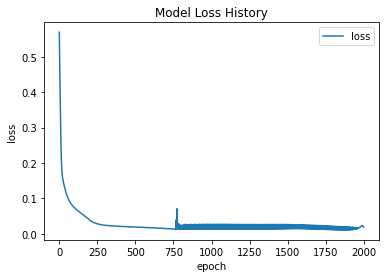

In [31]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Predicting with train data

This will also set predict input (previous input) into LSTM state which is useful to predict future value

In [32]:
train_predict = model.predict(X_train, batch_size=batch_size)

Predicting future value based on test data

In [33]:
days_to_predict = X_test.shape[0]
test_predict = []
pred_samples = train_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(X_test[i:(i+1)], batch_size=batch_size)
    pred = np.array(pred).flatten()
    test_predict.append(pred)
test_predict = np.array(test_predict).reshape(1, len(test_predict), 1)

Reset LSTM input state for safety

In [34]:
model.reset_states()

Getting actual based values by inverse them back

In [35]:
X_train_flatten = np.array(scaler.inverse_transform(
    np.array(X_train).reshape(X_train.shape[0], 1)
)).flatten().astype('int')
Y_train_flatten = np.array(scaler.inverse_transform(
    np.array(Y_train).reshape(Y_train.shape[0], 1)
)).flatten().astype('int')
train_predict_flatten = np.array(scaler.inverse_transform(
    np.array(train_predict).reshape(train_predict.shape[0], 1)
)).flatten().astype('int')
X_test_flatten = np.array(scaler.inverse_transform(
    np.array(X_test).reshape(X_test.shape[0], 1)
)).flatten().astype('int')
Y_test_flatten = np.array(scaler.inverse_transform(
    np.array(Y_test).reshape(Y_test.shape[0], 1)
)).flatten().astype('int')
test_predict_flatten = np.array(scaler.inverse_transform(
    np.array(test_predict).reshape(test_predict.shape[1], 1)
)).flatten().astype('int')

Getting RMSE scores

In [36]:
train_predict_score = math.sqrt(
    mean_squared_error(
        Y_train_flatten, 
        train_predict_flatten
    )
)
test_predict_score = math.sqrt(
    mean_squared_error(
        Y_test_flatten, 
        test_predict_flatten
    )
)

In [37]:
'Train Score: %.2f RMSE' % (train_predict_score)

'Train Score: 9.91 RMSE'

In [38]:
'Test Score: %.2f RMSE' % (test_predict_score)

'Test Score: 34.99 RMSE'

Plotting the model testing visualization

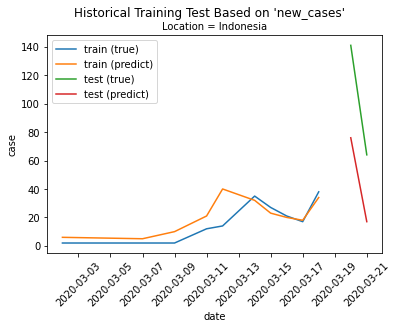

In [39]:
plt.plot(
    cases.index[:len(X_train_flatten)],
    X_train_flatten,
    label='train (true)'
)
plt.plot(
    cases.index[:len(train_predict_flatten)],
    train_predict_flatten,
    label='train (predict)'
)
plt.plot(
    cases.index[len(X_train_flatten):len(X_train_flatten) + len(X_test_flatten)],
    X_test_flatten,
    label='test (true)'
)
plt.plot(
    cases.index[len(X_train_flatten):len(X_train_flatten) + len(test_predict_flatten)],
    test_predict_flatten,
    label='test (predict)'
)
plt.suptitle('Historical Training Test Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Now we'll doing future prediction

Reset LSTM input state for safety

In [40]:
model.reset_states()

Fit the model with all data cases

In [41]:
epoch = EPOCHS
loss = []
for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_all, Y_all, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    model.reset_states()

Iteration 1/2000
Epoch 1/1
14/14 [==============================] - 0s 3ms/step - loss: 0.1237
Iteration 2/2000
Epoch 1/1
14/14 [==============================] - 0s 3ms/step - loss: 0.0947
Iteration 3/2000
Epoch 1/1
14/14 [==============================] - 0s 3ms/step - loss: 0.0829
Iteration 4/2000
Epoch 1/1
14/14 [==============================] - 0s 4ms/step - loss: 0.0837
Iteration 5/2000
Epoch 1/1
14/14 [==============================] - 0s 4ms/step - loss: 0.0829
Iteration 6/2000
Epoch 1/1
14/14 [==============================] - 0s 2ms/step - loss: 0.0809
Iteration 7/2000
Epoch 1/1
14/14 [==============================] - 0s 2ms/step - loss: 0.0791
Iteration 8/2000
Epoch 1/1
14/14 [==============================] - 0s 2ms/step - loss: 0.0776
Iteration 9/2000
Epoch 1/1
14/14 [==============================] - 0s 2ms/step - loss: 0.0764
Iteration 10/2000
Epoch 1/1
14/14 [==============================] - 0s 2ms/step - loss: 0.0754
Iteration 11/2000
Epoch 1/1
14/14 [==============

Plotting model loss history

Lower `loss` provide better prediction

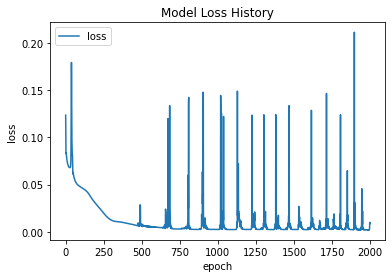

In [42]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Predicting with train data

This will also set predict input (previous input) into LSTM state which is useful to predict future value

In [66]:
all_predict = model.predict(X_all, batch_size=batch_size)

Predicting future value up to n-days

In our case, we're going to predict up to `DAYS_TO_PREDICT` days in the future

In [67]:
days_to_predict = DAYS_TO_PREDICT
future_predict = []
pred_samples = all_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(pred_samples, batch_size=batch_size)
    pred = np.array(pred).flatten()
    future_predict.append(pred)
    new_samples = np.array(pred_samples).flatten()
    new_samples = np.append(new_samples, [pred])
    new_samples = new_samples[1:]
    pred_samples = np.array(new_samples).reshape(1, 1, 1)
future_predict = np.array(future_predict).reshape(len(future_predict), 1, 1)

Reset LSTM input state for safety

In [68]:
model.reset_states()

Predict using previous future prediction

In [69]:
f_future_predict = model.predict(future_predict, batch_size=batch_size)

Reset LSTM input state for safety

In [70]:
model.reset_states()

In [71]:
X_all_flatten = np.array(scaler.inverse_transform(
    np.array(X_all).reshape(X_all.shape[0], 1)
)).flatten().astype('int')
X_all_flatten = np.absolute(X_all_flatten)
Y_all_flatten = np.array(scaler.inverse_transform(
    np.array(Y_all).reshape(Y_all.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten = np.absolute(Y_all_flatten)
all_predict_flatten = np.array(scaler.inverse_transform(
    np.array(all_predict).reshape(all_predict.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.absolute(all_predict_flatten)
future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(future_predict).reshape(future_predict.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten = np.absolute(future_predict_flatten)
f_future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(f_future_predict).reshape(f_future_predict.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten = np.absolute(f_future_predict_flatten)

Getting RMSE scores

In [72]:
all_predict_score = math.sqrt(
    mean_squared_error(
        Y_all_flatten, 
        all_predict_flatten
    )
)

In [73]:
'All Score: %.2f RMSE' % (all_predict_score)

'All Score: 5.66 RMSE'

Generate future index (dates)

In [74]:
future_index = pd.date_range(start=cases.index[-1], periods=days_to_predict + 1, closed='right')

Plotting future prediction visualization

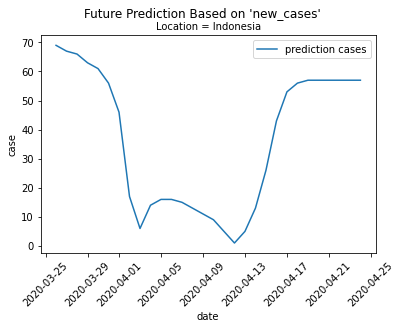

In [75]:
plt.plot(
    future_index,
    future_predict_flatten,
    label='prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Plotting f_future prediction visualization

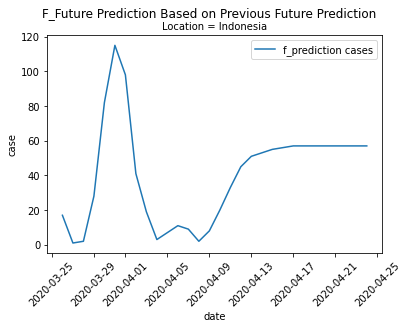

In [76]:
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_prediction cases'
)
plt.suptitle('F_Future Prediction Based on Previous Future Prediction')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

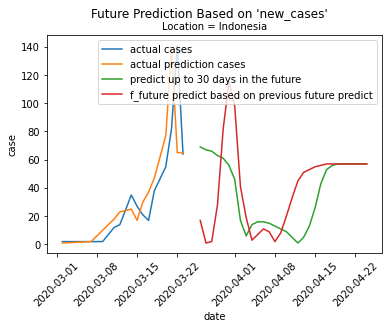

In [77]:
plt.plot(
    cases.index[:len(X_all_flatten)],
    X_all_flatten,
    label='actual cases'
)
plt.plot(
    cases.index[:len(X_all_flatten)],
    all_predict_flatten,
    label='actual prediction cases'
)
plt.plot(
    future_index,
    future_predict_flatten,
    label='predict up to ' + str(days_to_predict) + ' days in the future'
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_future predict based on previous future predict'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()